In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle as pkl

# Simulation code

## Functions which are used

In [13]:
def CreateNewGraph(r_0, kj, uf, l, maxTime):
    '''generate a graph with one street and parameters:
    r_0: request rate,
    kj: jam density,
    uf: free-flow speed,
    l: street length,
    maxTime: duration of simulation'''
    
    pathDict={
        0: {'timeSpan': SpanFunc(kj, uf, l, 0, maxTime), 'carsCount': 0}
    }
    
    carList = []
    deathCarLst = []
    
    return (carList, deathCarLst, pathDict)

In [16]:
def SetInitialCars(pathDict, carList, Nstart, kj, uf, l, maxTime):
    '''Initiate the cars which are already on the street at the beginning of a simulation;
    pathDict: dictionary of streets in the graph,
    carList: list of all cars which have been generated,
    Nstart: initial number of cars,
    kj: jam density,
    uf: free-flow speed,
    l: street length,
    maxTime: duration of simulation'''
    
    n=1
    if Nstart>0:
        for n in range(1, Nstart+1):
            chosen_path=0 #as this is a one-street network, there exists only one route option
            
            pathDict[chosen_path]['timeSpan']=SpanFunc(kj, uf, l, pathDict[chosen_path]['carsCount'], maxTime)
            pathDict[chosen_path]['carsCount']+=1
            
            carList.append( { 'path': chosen_path,
                    'nextEvent': currentTime + pathDict[chosen_path]['timeSpan'],
                    'startTime': currentTime,
                     'started': True,
                     'travelTime': 0, 
                     'endTime':100000
                    } )
    
    return (carList, pathDict)

In [5]:
def SpanFunc(kj, uf, l, numCars, maxTime):
    '''calculate the time span needed to travel the chosen street, depending on the current load;
    kj: jam density,
    uf: free-flow speed,
    l: street length,
    numCars: current number of cars on the street,
    maxTime: duration of simulation'''
    
    t0=l/uf
    k=numCars/l
    
    if numCars==0:
        newTimeSpan=t0
    elif k < kj:
        newTimeSpan=(kj*l)/(uf*(kj-k))  #using Greenshields' model 
    else: 
        newTimeSpan=maxTime
        
    return newTimeSpan

In [6]:
def carContinue(carList, carIdx):
    '''This function is called when the next event is a car event;
    carList: total list of cars generated,
    carIdx: car currently considered'''
    
    car = carList[carIdx]
    
    if car['started']==True:  #if the car is already on the street and is, thus, now leaving it
        #update the street network's state
        pathDict[car['path']]['carsCount'] -=1
        numCars = pathDict[car['path']]['carsCount']
        path = car['path']
        pathDict[path]['timeSpan'] = SpanFunc(kj, uf, l, numCars, maxTime)
        
        #update the information on the trip in the car list
        car['endTime'] = car['nextEvent']
        car['travelTime'] = car['endTime']-car['startTime']
        car['nextEvent']=1000000 #don't delete car, but make sure nothing happens for it anymore
        deathCarLst.append(carList[carIdx])
         
        
    else: #if the car has not yet entered the street
        #update the information on the trip in the car list
        path = car['path']
        car['nextEvent'] += pathDict[path]['timeSpan']
        car['started']=True
        
        #update the street network's state
        pathDict[path]['carsCount'] += 1
        numCars = pathDict[path]['carsCount']
        pathDict[path]['timeSpan'] = SpanFunc(kj, uf, l, numCars, maxTime)
        

In [7]:
def getNextStartEv(r_0, currentTime):
    '''Find next timepoint at which a car starts drawing from an exponential distribution with 
    a scale depending on r_0'''
    
    EvInterval=np.random.exponential(1/r_0, None) #draw time interval from the exponential distribution 1/r_0 * exp(dt/r_0)
    nextStartEv=currentTime+EvInterval
    
    return nextStartEv

In [8]:
def generateCar(currentTime):
    '''Add a car to the list of all cars, that will immediately start and enter the street'''
    chosen_path=0
    
    carList.append( { 'path': chosen_path,
                    'nextEvent': currentTime,
                    'startTime': currentTime,
                     'started': False,
                     'travelTime': 0, 
                     'endTime':100000
                    } )

## Initiate the parameters for the simulation

In [20]:
kj=60; 
uf=10; #in km/5min
l=1;

r00vals=[100, 140]
NstartVals=[12, 22] #start close to the first fixed point to get a realistic estimate of the escape time

numTurns=0
maxTurns=10 #number of realizations; for the paper, we used maxTurns=500

tracks={} #Dictionary to save the simulation output
OverfloatTimes=[]
StartEvents=[]

## Run the simulation

In [21]:
for idx, r_00 in enumerate(r00vals):
    print(r_00)
    numTurns=0
    Nstart=NstartVals[idx]
    
    tracks.update({r_00: {}})
    
    while(numTurns < maxTurns): #generate a number maxTurns of realizations
        print('Turn:', numTurns)
        
        currentTime = 0
        nextStartEv = 0
        maxTime = 100
        n = 0
        m = 0
        tracking=np.zeros((100, 2)) #save the time and the current number of cars on the street
        
        (carList, deathCarLst, pathDict)=CreateNewGraph(r_00, kj, uf, l, maxTime)
        (carList, pathDict)=SetInitialCars(pathDict, carList, Nstart, kj, uf, l, maxTime)
        
        while(currentTime <= maxTime):
            nextCarEv = 2*maxTime
            
            if len(carList)>=1:
                for carIdx, car in enumerate(carList): #scan through list of cars and find the one that will enter or leave next
                    if car['nextEvent'] <= nextCarEv:
                        nextCarEv = car['nextEvent']
                        nextCarEvIdx = carIdx

            if nextStartEv < nextCarEv: 
                currentTime = nextStartEv
                generateCar(currentTime) #create car
                nextStartEv=getNextStartEv(r_00, currentTime)
                StartEvents.append(nextStartEv-currentTime)
            
                #count the number of cars currently on the street
                if n >= tracking.shape[0]:
                    tracking=np.resize(tracking,(2*n,2))
                
                tracking[n][0]=currentTime
                tracking[n][1]=pathDict[0]['carsCount']
                
                n+=1
                
                #to save computational time, stop the simulation when the street is definitely congested
                if pathDict[0]['carsCount'] > 300:
                    currentTime=maxTime+1
                    print('interrupted this turn') 
            
            else: #continue a trip of a car
                currentTime = nextCarEv
                carContinue(carList, nextCarEvIdx)

    
        tracking=np.resize(tracking,(n,2)) # delete empty elements in the tracking matrix
        tracks[r_00].update({numTurns: tracking})
        numTurns+=1


100
Turn: 0
Turn: 1
Turn: 2
Turn: 3
Turn: 4
Turn: 5
Turn: 6
Turn: 7
Turn: 8
Turn: 9
140
Turn: 0
interrupted this turn
Turn: 1
interrupted this turn
Turn: 2
interrupted this turn
Turn: 3
interrupted this turn
Turn: 4
interrupted this turn
Turn: 5
interrupted this turn
Turn: 6
interrupted this turn
Turn: 7
interrupted this turn
Turn: 8
interrupted this turn
Turn: 9
interrupted this turn


## Analyze the outcome

To analyze the results, we first adapt the output in such a way, that all street loads above the jamming density are set to kj, which is the street load at which the vehicle velocity drops to zero.

In [22]:
adapted_tracks=tracks.copy()

for r_00 in tracks:
    for turn in tracks[r_00]:
        for idx, numcars in enumerate(adapted_tracks[r_00][turn][:, 1]):
            if numcars > kj:
                adapted_tracks[r_00][turn][idx, 1]=kj

To find a histogram of the vehicle densities corresponding to several time points in the simulations of the two request rates, we save the results from all realizations in dictionaries for each request rate.

In [33]:
timevals=np.array([1,5,10,20, 40, 80])
corr_times=timevals/5 #as we have simulated in units of 5 minutes

timedict_stable={}
timedict_unstable={}
for time in corr_times:
    timedict_stable.update({time: []})
    timedict_unstable.update({time:[]})
    for turn in range(0, maxTurns):
        
        corr_idx=np.where(adapted_tracks[r_00vals[0]][turn][:,0] > time)[0][0]
        car_density=adapted_tracks[r_00vals[0]][turn][corr_idx,1]
        
        timedict_stable[time].append(car_density)
        
        try:
            corr_idx_us=np.where(adapted_tracks[r_00vals[1]][turn][:,0] > time)[0][0]
            car_density_us=adapted_tracks[r_00vals[1]][turn][corr_idx_us,1]   
            
        except:
            car_density_us=kj
            
        timedict_unstable[time].append(car_density_us)

Now we plot the histograms, together with the predicted stable fixed points which we find from our semi-analytic calculations.

Text(0, 0.5, 'vehicle density')

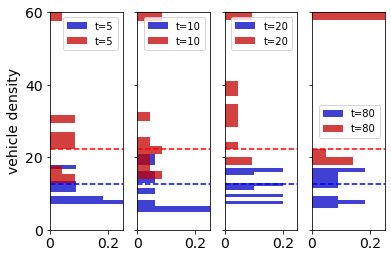

In [34]:
fig, axs=plt.subplots(1, 4, sharey=True)

axs[0].hist(timedict_stable[1], orientation='horizontal', density=True, label='t=5', color=(0,0,196/255), alpha=0.75)
axs[1].hist(timedict_stable[2], orientation='horizontal', density=True, label='t=10', color=(0,0,196/255), alpha=0.75)
axs[2].hist(timedict_stable[4], orientation='horizontal', density=True, label='t=20', color=(0,0,196/255), alpha=0.75)
axs[3].hist(timedict_stable[16], orientation='horizontal', density=True, label='t=80', color=(0,0,196/255), alpha=0.75)

axs[0].plot(np.arange(0, 1.2, 0.01), np.repeat(12.6795, len(np.arange(0, 1.2, 0.01))), '--', color='blue')
axs[1].plot(np.arange(0, 1.2, 0.01), np.repeat(12.6795, len(np.arange(0, 1.2, 0.01))), '--', color='blue')
axs[2].plot(np.arange(0, 1.2, 0.01), np.repeat(12.6795, len(np.arange(0, 1.2, 0.01))), '--', color='blue')
axs[3].plot(np.arange(0, 1.2, 0.01), np.repeat(12.6795, len(np.arange(0, 1.2, 0.01))), '--', color='blue')

axs[0].hist(timedict_unstable[1], orientation='horizontal', density=True, bins=20, label='t=5', color=(196/255, 0, 0), alpha=0.75)
axs[1].hist(timedict_unstable[2], orientation='horizontal', density=True, bins=20, label='t=10', color=(196/255, 0, 0), alpha=0.75)
axs[2].hist(timedict_unstable[4], orientation='horizontal', density=True, bins=20, label='t=20', color=(196/255, 0, 0), alpha=0.75)
axs[3].hist(timedict_unstable[16], orientation='horizontal', density=True, bins=20, label='t=80', color=(196/255, 0, 0), alpha=0.75)

axs[0].plot(np.arange(0, 1.2, 0.01), np.repeat(22.254, len(np.arange(0, 1.2, 0.01))), '--', color='red')
axs[1].plot(np.arange(0, 1.2, 0.01), np.repeat(22.254, len(np.arange(0, 1.2, 0.01))), '--', color='red')
axs[2].plot(np.arange(0, 1.2, 0.01), np.repeat(22.254, len(np.arange(0, 1.2, 0.01))), '--', color='red')
axs[3].plot(np.arange(0, 1.2, 0.01), np.repeat(22.254, len(np.arange(0, 1.2, 0.01))), '--', color='red')

axs[0].set_xlim((0, 0.25))
axs[1].set_xlim((0, 0.25))
axs[2].set_xlim((0, 0.25))
axs[3].set_xlim((0, 0.25))
axs[0].set_ylim((0, 60))
axs[1].set_ylim((0, 60))
axs[2].set_ylim((0, 60))
axs[3].set_ylim((0, 60))

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

axs[0].set_yticks(np.arange(0,71,20))
axs[0].set_xticks(np.arange(0,0.25,0.2))
axs[0].set_yticklabels(np.arange(0,71,20), fontsize=14)
axs[0].set_xticklabels([0, 0.2], fontsize=14)

axs[1].set_yticks(np.arange(0,71,20))
axs[1].set_xticks(np.arange(0,0.25,0.2))
axs[1].set_yticklabels(np.arange(0,71,20), fontsize=14)
axs[1].set_xticklabels([0, 0.2], fontsize=14)

axs[2].set_yticks(np.arange(0,71,20))
axs[2].set_xticks(np.arange(0,0.25,0.2))
axs[2].set_yticklabels(np.arange(0,71,20), fontsize=14)
axs[2].set_xticklabels([0, 0.2], fontsize=14)

axs[3].set_yticks(np.arange(0,71,20))
axs[3].set_xticks(np.arange(0,0.25,0.2))
axs[3].set_yticklabels(np.arange(0,71,20), fontsize=14)
axs[3].set_xticklabels([0, 0.2], fontsize=14)

axs[0].set_ylabel("vehicle density", fontsize=14)

We can also display the vehicle densities as a function of time for specific realizations:

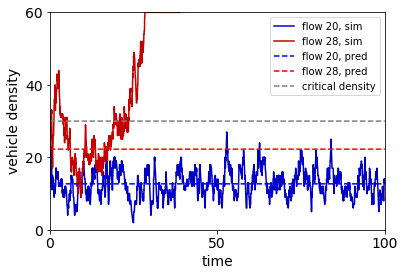

In [39]:
run=0

fig, ax = plt.subplots()
plt.plot(adapted_tracks[r_00vals[0]][run][:,0], adapted_tracks[r_00vals[0]][run][:,1], '-', color=(0,0,196/255), label='flow 20, sim')
plt.plot(adapted_tracks[r_00vals[1]][run][:,0], adapted_tracks[r_00vals[1]][run][:,1], '-', color=(196/255, 0, 0), label='flow 28, sim')
plt.plot(adapted_tracks[r_00vals[0]][run][:,0], np.repeat(12.6795, len(adapted_tracks[r_00vals[0]][run][:,0])), 'b--', label='flow 20, pred')
plt.plot(np.arange(0, 40, 0.01), np.repeat(22.254, len(np.arange(0, 40, 0.01))), 'r--', label='flow 28, pred')

plt.plot(np.arange(0, 40, 0.01), np.repeat(30, len(np.arange(0, 40, 0.01))), linestyle='--',color='grey', label='critical density')

plt.xlim((0,20))
plt.ylim((0,60))

plt.xlabel('time', fontsize=14)
plt.ylabel('vehicle density', fontsize=14)

ax.set_yticks(np.arange(0,65,20))
ax.set_xticks(np.arange(0,30,10))

ax.set_yticklabels(np.arange(0,65,20), fontsize=14)
ax.set_xticklabels(np.arange(0,150,50), fontsize=14)

plt.legend()